In [1]:
# Imports

!pip install smogn
!pip install lightgbm
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
import catboost as cb
from sklearn.metrics import mean_squared_error
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
import catboost as cb
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
import sklearn
from sklearn.decomposition import PCA
from time import time
from sklearn.feature_selection import RFECV
from sklearn import metrics
from sklearn.cluster import DBSCAN, KMeans
import catboost as cb
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer
import smogn
import lightgbm as lgb 
import seaborn as sns
from scipy.stats import norm, probplot
from sklearn.pipeline import make_pipeline
import catboost as cb
from sklearn.metrics import mean_squared_error
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
import catboost as cb
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
import sys
import logging
from sklearn.ensemble import VotingRegressor

Config option `kernel_spec_manager_class` not recognized by `EnableNBExtensionApp`.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# EDA

I am going to 

* review the data
* remove outliers
* replace NaN's
* create few simple features
* get rid of unimprtant features

In [2]:
# Function to replace values in a column
def replace_vals_in_col(col, vals, data):
    return data[col].replace(vals)

# Load the data and seperate
X_train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
X_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

RUN_RFECV = False
RUN_TUNING = False
CROSS_VAL = True
SAMPLE_SUBMISSION_PATH = "/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv"
SUBMISSION_PATH = "submission.csv"
TARGET = "SalePrice"
MODEL = 'vote'

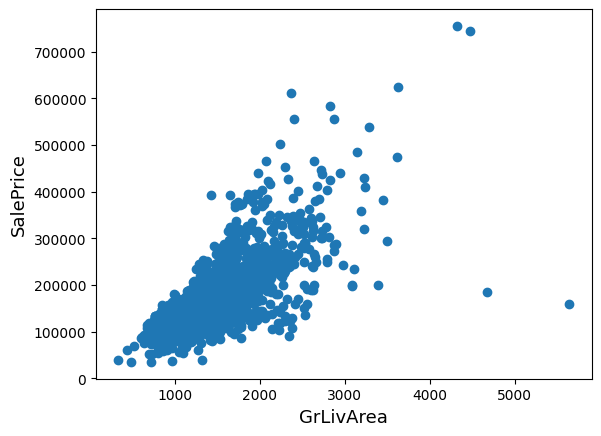

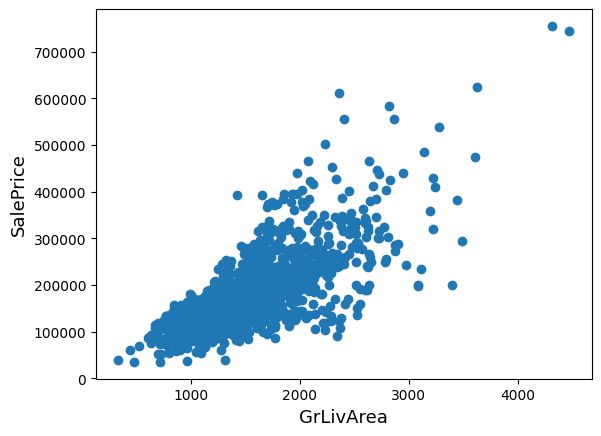

In [3]:
# Plot GrLivArea and SalePrice 
fig, ax = plt.subplots()
ax.scatter(x = X_train['GrLivArea'], y = X_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

#Deleting outliers
X_train.drop(X_train[(X_train['GrLivArea']>4000) & (X_train['SalePrice']<300000)].index, inplace=True)

# GrLivArea and SalePrice after deleting outliers
fig, ax = plt.subplots()
ax.scatter(x = X_train['GrLivArea'], y = X_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

/tmp/ipykernel_18/1576006462.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train['SalePrice'] , fit=norm);
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



 mu = 180932.92 and sigma = 79467.79



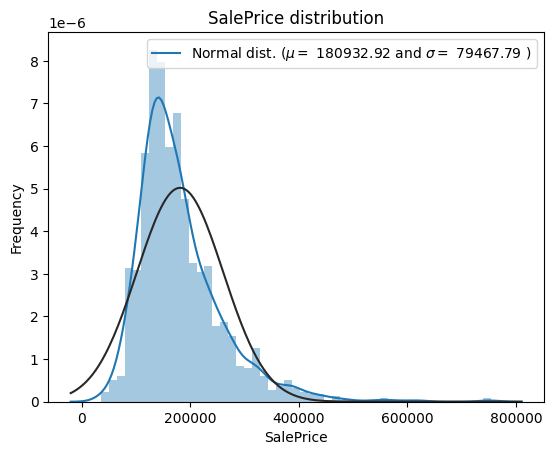

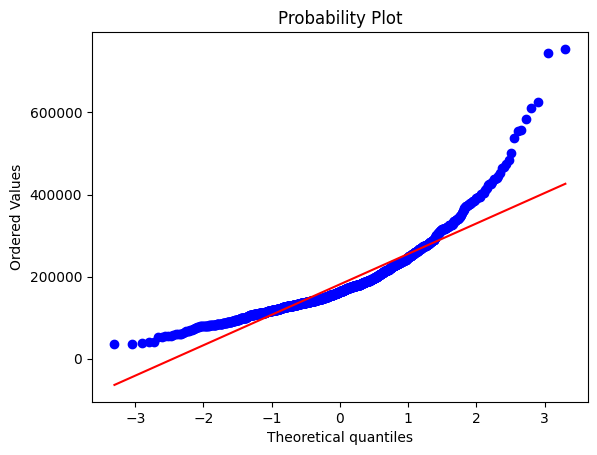

In [4]:
# Some analysis on SalePrice

sns.distplot(X_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(X_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = probplot(X_train['SalePrice'], plot=plt)
plt.show()

/tmp/ipykernel_18/3121029742.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train['SalePrice'] , fit=norm);
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



 mu = 12.02 and sigma = 0.40



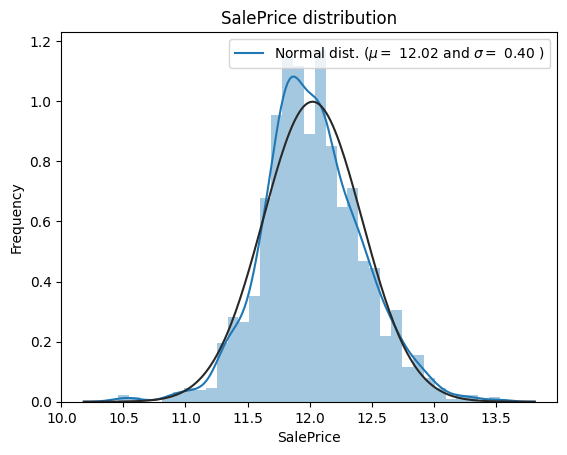

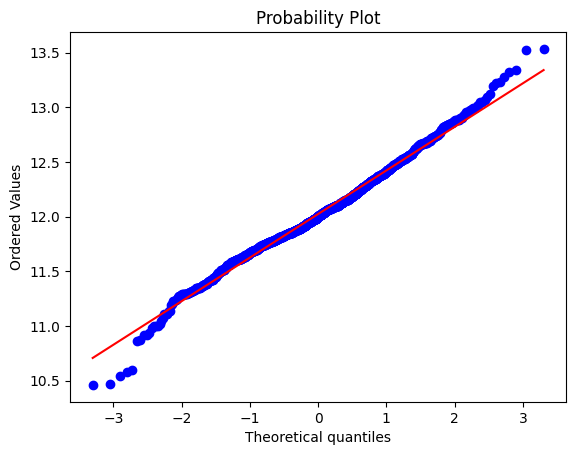

In [5]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
X_train["SalePrice"] = np.log1p(X_train["SalePrice"])

#Check the new distribution 
sns.distplot(X_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(X_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = probplot(X_train['SalePrice'], plot=plt)
plt.show()

In [6]:
# Missing Data
y_train = X_train.SalePrice.values
combined = pd.concat((X_train, X_test)).reset_index(drop=True)
combined.drop(['SalePrice'], axis=1, inplace=True)
print("combined size is : {}".format(combined.shape))

combined_na = (combined.isnull().sum() / len(combined)) * 100
combined_na = combined_na.drop(combined_na[combined_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :combined_na})
missing_data

combined size is : (2917, 80)


,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
MasVnrType,60.541652
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageQual,5.450806
GarageCond,5.450806


Text(0.5, 1.0, 'Percent missing data by feature')

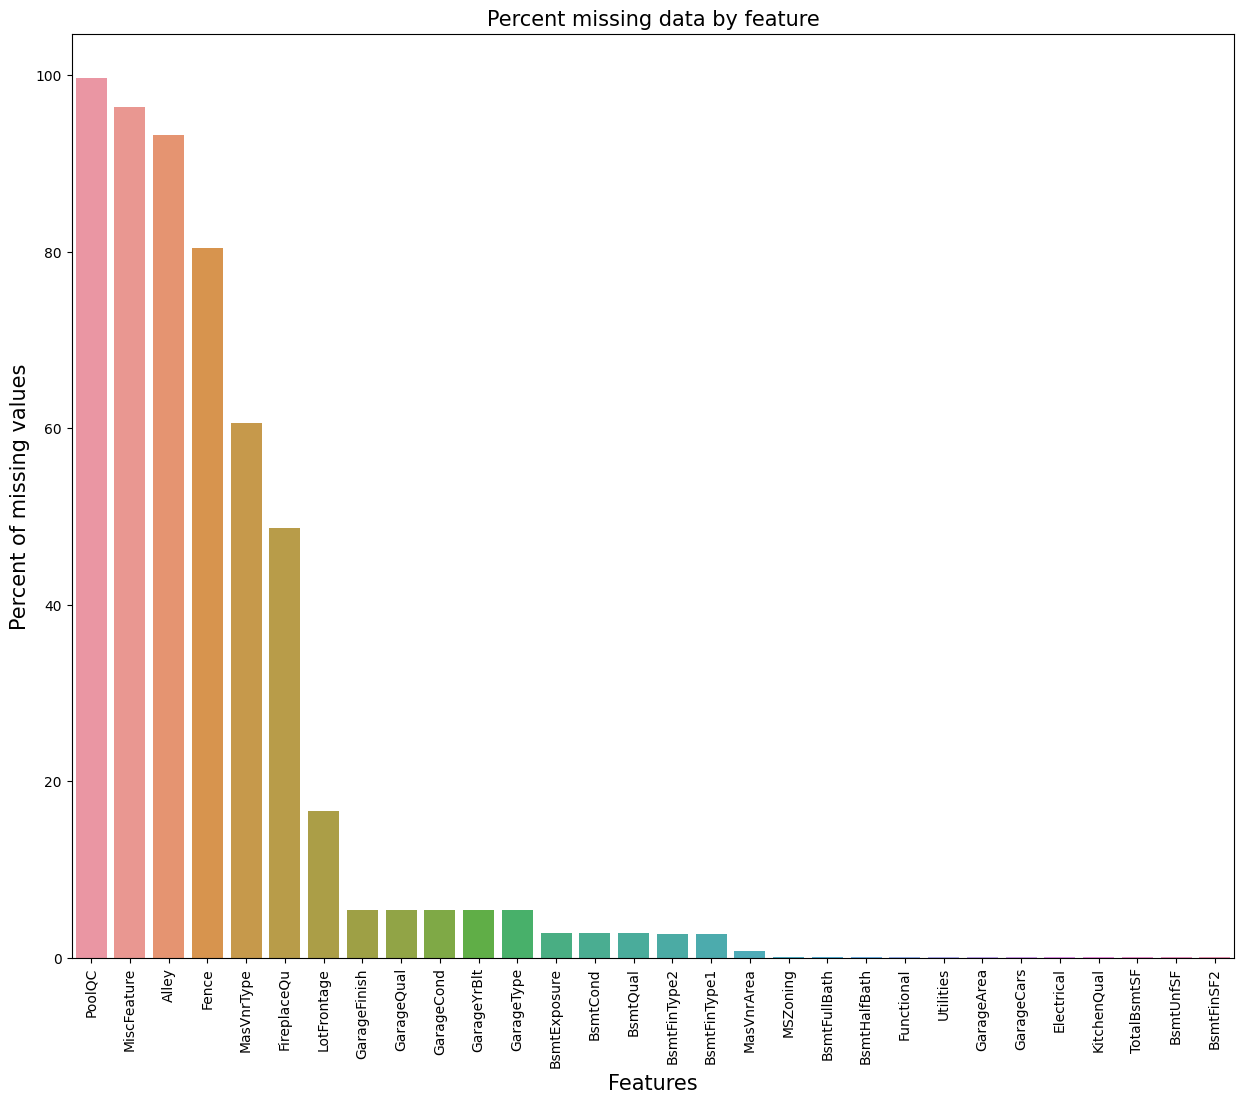

In [7]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(x=combined_na.index, y=combined_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [8]:
# Seperate y train from train data
y_train = X_train['SalePrice']
X_train.drop(columns=['SalePrice'], inplace=True)

# To detect train and test data in future
X_train['train'] = 1
X_test['train'] = 0

# Combine for ease
combined = pd.concat([X_train, X_test], ignore_index=True)
combined.drop(columns=['Id'], inplace=True)

cat_features = combined.select_dtypes(include=['object']).columns.tolist()

for col in cat_features:
    combined[col] = combined[col].astype(str)

# Replace nan's
combined['Functional'] = combined['Functional'].fillna('Typ')
combined['Electrical'] = combined['Electrical'].fillna("SBrkr")
combined['KitchenQual'] = combined['KitchenQual'].fillna("TA")
combined['Exterior1st'] = combined['Exterior1st'].fillna(combined['Exterior1st'].mode()[0])
combined['Exterior2nd'] = combined['Exterior2nd'].fillna(combined['Exterior2nd'].mode()[0])
combined['SaleType'] = combined['SaleType'].fillna(combined['SaleType'].mode()[0])
combined["PoolQC"] = combined["PoolQC"].fillna("None")
combined['LotFrontage'] = combined.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
combined['MSZoning'] = combined.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# If no garage or basement
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    combined[col] = combined[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    combined[col] = combined[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    combined[col] = combined[col].fillna('None')

# Create new features, which indicate to whole

combined['YrBltAndRemod']=combined['YearBuilt']+combined['YearRemodAdd']
combined['TotalSF']=combined['TotalBsmtSF'] + combined['1stFlrSF'] + combined['2ndFlrSF']

combined['Total_sqr_footage'] = (combined['BsmtFinSF1'] + combined['BsmtFinSF2'] +
                                 combined['1stFlrSF'] + combined['2ndFlrSF'])

combined['Total_Bathrooms'] = (combined['FullBath'] + (0.5 * combined['HalfBath']) +
                               combined['BsmtFullBath'] + (0.5 * combined['BsmtHalfBath']))

combined['Total_porch_sf'] = (combined['OpenPorchSF'] + combined['3SsnPorch'] +
                              combined['EnclosedPorch'] + combined['ScreenPorch'] +
                              combined['WoodDeckSF'])


# simplified features
combined['haspool'] = combined['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
combined['has2ndfloor'] = combined['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
combined['hasgarage'] = combined['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
combined['hasbsmt'] = combined['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
combined['hasfireplace'] = combined['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# Fill numericals with 0's

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in combined.columns:
    if combined[i].dtype in numeric_dtypes:
        numerics.append(i)
combined.update(combined[numerics].fillna(0))

# Change some categorical features to numericals
cat_to_num_features_1 = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond', 'PoolQC', 'FireplaceQu']
cat_to_num_features_5 = ['BsmtFinType1', 'BsmtFinType2']

for cat in cat_to_num_features_1:
    combined[cat] = replace_vals_in_col(cat, {'Po' : 0, 'Fa': 1, 'TA':2, 'Gd':3, 'Ex':4, 'nan' : 0}, data=combined)

for cat in cat_to_num_features_5:
    combined[cat] = replace_vals_in_col(cat, {'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6, 'nan' : 0}, data=combined)    

combined['LandSlope'] = replace_vals_in_col('LandSlope', {'Gtl' : 2, 'Mod': 1, 'Sev':0, 'nan' : 0}, data=combined)
combined['BsmtExposure'] = replace_vals_in_col('BsmtExposure', {'No' : 0, 'Mn': 1, 'Av':2, 'Gd':3, 'nan' : 0},data=combined)
combined['PavedDrive'] = replace_vals_in_col('PavedDrive', {'N' : 0, 'P': 1, 'Y':2, 'nan' : 0}, data=combined)
combined['LotShape'] = replace_vals_in_col('LotShape', {'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3, 'nan' : 0}, data=combined)
combined['Electrical'] = replace_vals_in_col('Electrical', {'Mix': 0, 'FuseP': 1, 'FuseF': 2, 'FuseA': 3, 'SBrkr':4, 'nan' : 0}, data=combined)
combined['Functional'] = replace_vals_in_col('Functional', {'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7, 'nan' : 0}, data=combined)
combined['Utilities'] = replace_vals_in_col('Utilities', {'ELO': 0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3, 'nan' : 0}, data=combined)

# Drop features with a lot of nan's
combined.drop(columns = ['Utilities', 'Street', 'PoolQC'], inplace=True)

# Convert non-numeric columns to strings explicitly to ensure correct dtype
cat_features = combined.select_dtypes(include=['object']).columns.tolist()

# One Hot encoding
combined = pd.get_dummies(combined, columns=cat_features, dtype='int')

cat_features = combined.select_dtypes(include=['object']).columns.tolist()

/tmp/ipykernel_18/890350171.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return data[col].replace(vals)


<Axes: >

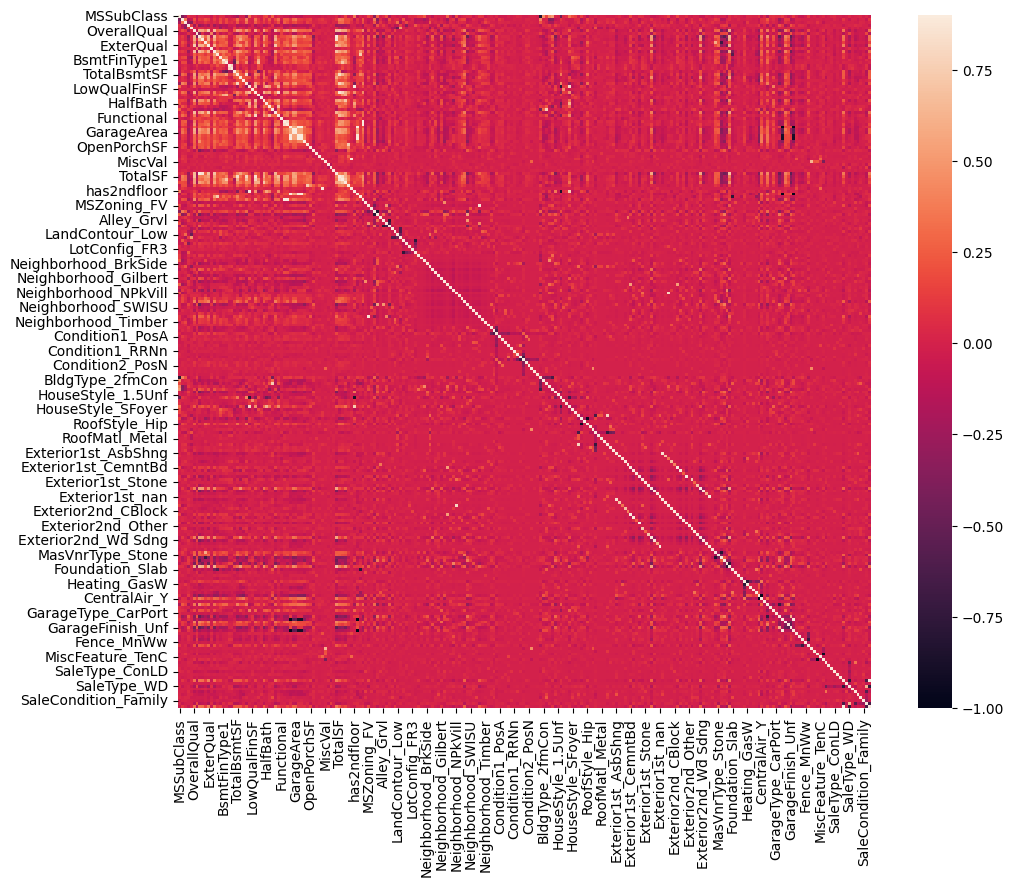

In [9]:
#Correlation map to see how features are correlated with SalePrice
corrmat = combined.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [10]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(f"Are there any NaN values? {combined.isna().any().any()}")
    
# Seperate train and test data from combined

X_train = combined[combined["train"] == 1].copy()
X_test = combined[combined["train"] == 0].copy()
X_train.drop(columns=['train'], inplace=True)
X_test.drop(columns=['train'], inplace=True)

# Split the training data
X_train_d, X_val_d, y_train_d, y_val_d = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

if RUN_RFECV:
    # RFECV: Run and delete unimprtant features

    # Create a basic CatBoost Regressor for importance measure
    train_data = cb.Pool(data=X_train_d, label=y_train_d)
    eval_data = cb.Pool(data=X_val_d, label=y_val_d)

    model_cb = cb.CatBoostRegressor(silent=True, loss_function='RMSE', early_stopping_rounds=100, eval_metric='RMSE')
    model_cb.fit(train_data, eval_set=eval_data, silent=True)

    # Feature improtances
    f_i = list(zip(X_train.columns, model_cb.get_feature_importance(train_data)))
    f_i.sort(key = lambda x : x[1])

    # RFECV
    rfe = RFECV(model_cb,cv=5,scoring="neg_mean_squared_error", verbose=10)
    rfe.fit(X_train,y_train)

    # Get the non selected features
    selected_features = np.array(X_train.columns)[rfe.get_support()]
    non_rfecv_sel_features = [ i for i in X_train.columns if i not in selected_features]

else:
    non_rfecv_sel_features = ['Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_NPkVill', 'Condition2_PosA', 'Exterior1st_Stone', 'Exterior2nd_nan', 'Heating_Floor', 'Heating_OthW']

print(f"Non RFECV selected features: {non_rfecv_sel_features}")

# Remove RFECV NOT selected features from data
X_train.drop(columns=non_rfecv_sel_features, inplace=True)
X_test.drop(columns=non_rfecv_sel_features, inplace=True)

X_train

Are there any NaN values? False
Non RFECV selected features: ['Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_NPkVill', 'Condition2_PosA', 'Exterior1st_Stone', 'Exterior2nd_nan', 'Heating_Floor', 'Heating_OthW']


,MSSubClass,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,3,2,7,5,2003,2003,196.0,...,0,0,1,0,0,0,0,0,1,0
1,20,80.0,9600,3,2,6,8,1976,1976,0.0,...,0,0,1,0,0,0,0,0,1,0
2,60,68.0,11250,2,2,7,5,2001,2002,162.0,...,0,0,1,0,0,0,0,0,1,0
3,70,60.0,9550,2,2,7,5,1915,1970,0.0,...,0,0,1,0,1,0,0,0,0,0
4,60,84.0,14260,2,2,8,5,2000,2000,350.0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,60,62.0,7917,3,2,6,5,1999,2000,0.0,...,0,0,1,0,0,0,0,0,1,0
1454,20,85.0,13175,3,2,6,6,1978,1988,119.0,...,0,0,1,0,0,0,0,0,1,0
1455,70,66.0,9042,3,2,7,9,1941,2006,0.0,...,0,0,1,0,0,0,0,0,1,0
1456,20,68.0,9717,3,2,5,6,1950,1996,0.0,...,0,0,1,0,0,0,0,0,1,0


# Hyperparameter tuning

I am going to do this with optuna, here are few models for it

* CatBoost
* XGBoost
* LGBM
* Linear Regression

In [11]:
# Define objectives for optuna for CatBoost, XGBoost and LGBM

def objective_catboost(trial):
    time_now = time()
    
    param = {}
    param['depth'] = trial.suggest_int('depth', 1, 16)
    param['l2_leaf_reg'] = trial.suggest_float('l2_leaf_reg', 0.001, 5.0)
    param['min_child_samples'] = trial.suggest_int('min_child_samples', 1, 16)
    param['grow_policy'] = 'Depthwise'
    param['colsample_bylevel'] = trial.suggest_float('colsample_bylevel', 0.001, 1.0)
    param['random_strength'] = trial.suggest_float('random_strength', 1, 10)
    param['n_estimators'] = trial.suggest_int('n_estimators', 50, 5000)
    param['eval_metric'] = 'RMSE'
    param['random_state'] = 42
    param['logging_level'] = 'Silent'
#     param['task_type'] = 'GPU'
    param['loss_function'] = 'RMSE'

    regressor = cb.CatBoostRegressor(**param, early_stopping_rounds=100)
    
    scores = cross_val_score(regressor, X_train.copy(), y_train.copy(), cv=5, scoring='neg_root_mean_squared_error')
    
    print("time passed: ", time() - time_now)
    
    return np.min([np.mean(scores), np.median([scores])])

def objective_xgb(trial):
    param = {}
    
    param['lambda'] = trial.suggest_float('lambda', 1.0, 5.0)
    param['subsample'] = trial.suggest_float('subsample', 0.001, 1.0)
    param['colsample_bytree'] = trial.suggest_float('colsample_bytree', 0.001, 1.0)
    param['learning_rate'] = trial.suggest_float('learning_rate', 0.001, 1.0)
    param['n_estimators'] = trial.suggest_int('n_estimators', 50, 4000)
    param['eval_metric'] = 'rmse'
    param['random_state'] = 42
    param['objective'] = 'reg:squarederror'
    param['verbosity'] = 0
    param['task_type'] = 'GPU'

    regressor = xgb.XGBRegressor(**param, tree_method="hist", device="cuda")
#     regressor = xgb.XGBRegressor(**param)
    scores = cross_val_score(regressor, X_train.copy(), y_train.copy(), cv=5, scoring='neg_root_mean_squared_error')
    
    return np.min([np.mean(scores), np.median([scores])])  

def objective_lgbm(trial):
    hyper_params = {
                    'n_estimators'     : trial.suggest_int('n_estimators', 100, 5000),
                    'learning_rate'    : trial.suggest_float('learning_rate', 1e-5, 0.1, log=True),
                    'num_leaves'       : trial.suggest_int('num_leaves', 31, 512),
                    'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
                    'subsample_freq'   : trial.suggest_int('subsample_freq', 1, 100),
                    'subsample'        : trial.suggest_float('subsample', 0.5, 1.0),
                    'colsample_bytree' : trial.suggest_float('colsample_bytree', 0, 1.0),
                    'reg_alpha'        : trial.suggest_float('reg_alpha', 1e-6, 20, log=True),
                    'reg_lambda'       : trial.suggest_float('reg_lambda', 1e-6, 20, log=True),
                    'max_depth'        : trial.suggest_int('max_depth', 5, 32),
                    'max_bin'          : trial.suggest_int('max_bin', 6, 32)
                   }


    lgbmreg = lgb.LGBMRegressor(**hyper_params, verbosity=-1)
    scores = cross_val_score(lgbmreg, X_train.copy(), y_train.copy(), cv=5, scoring='neg_root_mean_squared_error')
    
    return np.min([np.mean(scores), np.median([scores])]) 

In [12]:
# Hyperparameter tuning for the models

if RUN_TUNING:
    # CatBoost
    study_cb = optuna.create_study(direction='maximize')
    study_cb.optimize(objective_catboost, n_trials=200, n_jobs=-1)

    # XGBoost
    study_xgb = optuna.create_study(direction='maximize')
    study_xgb.optimize(objective_xgb, n_trials=200, n_jobs=-1)

    # LGBM
    study_lgbm = optuna.create_study(direction='maximize')
    study_lgbm.optimize(objective_lgbm, n_trials=200, n_jobs=-1)
    
    print(study_cb.best_params, study_xgb.best_params, study_lgbm.best_params)

# Run and evaluate the models

In [13]:
X_train_d, X_val_d, y_train_d, y_val_d = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

if RUN_TUNING:
    params_cb = study_cb.best_params
    params_xgb = study_xgb.best_params
    params_lgbm = study_lgbm.best_params

else:
    params_cb = {'depth': 4, 'l2_leaf_reg': 4.652273686269154, 'min_child_samples': 1, 'colsample_bylevel': 0.0704138264279591, 'random_strength': 4.609312498311535, 'n_estimators': 1924}
    params_xgb = {'lambda': 2.0559704409164117, 'subsample': 0.2491122512318991, 'colsample_bytree': 0.3844437277182913, 'learning_rate': 0.006169371631223933, 'n_estimators': 3702}
    params_lgbm = {'n_estimators': 3033, 'learning_rate': 0.0033326885467721795, 'num_leaves': 384, 'min_child_samples': 15, 'subsample_freq': 55, 'subsample': 0.7147364364733713, 'colsample_bytree': 0.25761432740834694, 'reg_alpha': 0.00043043575969990423, 'reg_lambda': 0.05118368380160862, 'max_depth': 24, 'max_bin': 28}


# Cat Boost
train_data = cb.Pool(data=X_train_d, label=y_train_d)
eval_data = cb.Pool(data=X_val_d, label=y_val_d)

model_cb = cb.CatBoostRegressor(**params_cb, silent=True, loss_function='RMSE', early_stopping_rounds=100, eval_metric='RMSE', grow_policy = 'Depthwise')

if CROSS_VAL:
    scores_cb = cross_val_score(model_cb, X_train.copy(), y_train.copy(), cv=5, scoring='neg_root_mean_squared_error')
    print("Scores CB: ", scores_cb)

model_cb.fit(train_data, eval_set=eval_data)
predictions_cb = model_cb.predict(X_val_d)

# XGBoost

xgb.set_config(verbosity=0)

model_xgb = xgb.XGBRegressor(**params_xgb, verbosity=0, eval_metric='rmse', random_state=42, objective='reg:squarederror', tree_method="hist", device="cuda")

if CROSS_VAL:
    scores_xgb = cross_val_score(model_xgb, X_train.copy(), y_train.copy(), cv=5, scoring='neg_root_mean_squared_error')
    print("Scores XGB: ", scores_xgb)

    model_xgb = xgb.XGBRegressor(**params_xgb, verbosity=0, eval_metric='rmse', random_state=42, objective='reg:squarederror', tree_method="hist", device="cuda")
model_xgb.fit(X_train_d.copy(), y_train_d.copy(), verbose=True)
predictions_xgb = model_xgb.predict(X_val_d)

# LGBM

model_lgbm = lgb.LGBMRegressor(**params_lgbm, verbosity=-1)

if CROSS_VAL:
    scores_lgbm = cross_val_score(model_lgbm, X_train.copy(), y_train.copy(), cv=5, scoring='neg_root_mean_squared_error')
    print("Scores LGBM: ", scores_lgbm)

model_lgbm.fit(X_train_d.copy(), y_train_d.copy())
predictions_lgbm = model_lgbm.predict(X_val_d)

# Linear Regression

model_lr = LinearRegression()

if CROSS_VAL:
    scores_lr = cross_val_score(model_lr, X_train.copy(), y_train.copy(), cv=5, scoring='neg_root_mean_squared_error')
    print("Scores Linear Regression: ", scores_lr)

model_lr.fit(X_train_d.copy(), y_train_d.copy())
predictions_lr = model_lr.predict(X_val_d)

# Count the RMSLE's

rmse_cb = mean_squared_error(y_val_d, predictions_cb, squared=False)
rmse_xgb = mean_squared_error(y_val_d, predictions_xgb, squared=False)
rmse_lgbm = mean_squared_error(y_val_d, predictions_lgbm, squared=False)
rmse_lr = mean_squared_error(y_val_d, predictions_lr, squared=False)

print(f"RMSLE for CatBoost: {rmse_cb}")
print(f"RMSLE for XGBoost: {rmse_xgb}")
print(f"RMSLE for LGBM: {rmse_lgbm}")
print(f"RMSLE for Linear Regression: {rmse_lr}")

Scores CB:  [-0.10583351 -0.1160276  -0.11625212 -0.10290116 -0.10855547]
Scores XGB:  [-0.10621603 -0.11485003 -0.12099136 -0.10115834 -0.10888498]
Scores LGBM:  [-0.10939797 -0.11971306 -0.12477664 -0.10839056 -0.11094359]
Scores Linear Regression:  [-0.12012523 -0.13167493 -0.13249342 -0.11463412 -0.11933785]
RMSLE for CatBoost: 0.11509991436090466
RMSLE for XGBoost: 0.11804935344470255
RMSLE for LGBM: 0.11907226596673859
RMSLE for Linear Regression: 0.13214762641020233


In [14]:
def voting_weigths(scores):
    scores -= scores.max() # minus the biggest error to see the difference between scores 
    stds = np.std(-scores) # Standart deviation
    scores = -scores.mean(axis=1) # mean of scores
    scores = np.ones(4) / (scores + stds)
    return scores / np.sum(scores) # to add up to 1

if CROSS_VAL:
    print(voting_weigths(np.array([scores_cb, scores_xgb, scores_lgbm, scores_lr])))

[0.30178023 0.2931913  0.23691923 0.16810924]


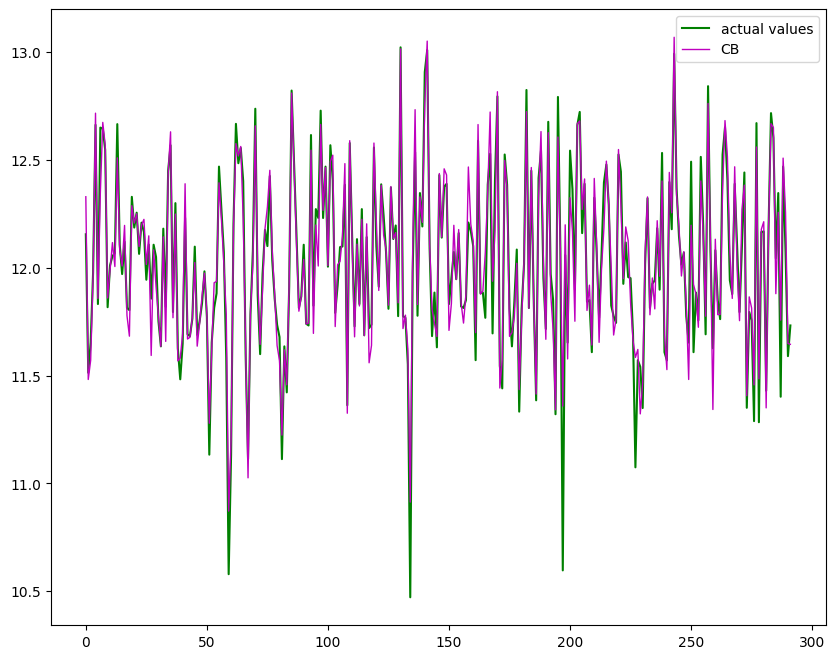

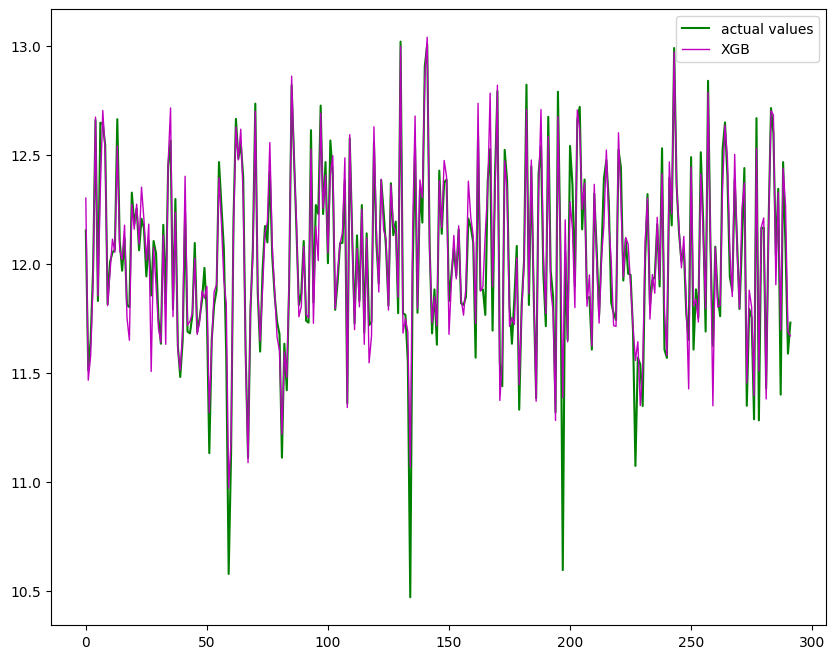

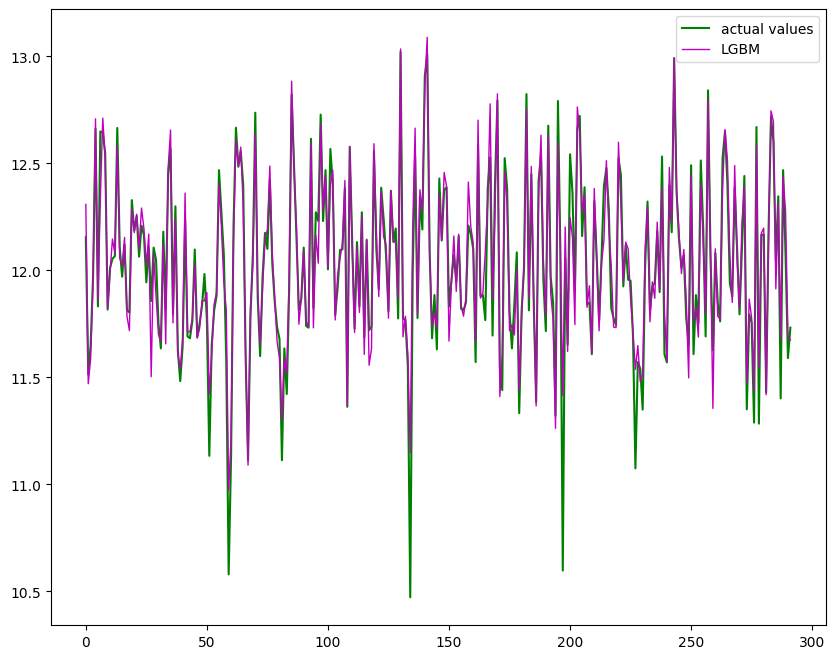

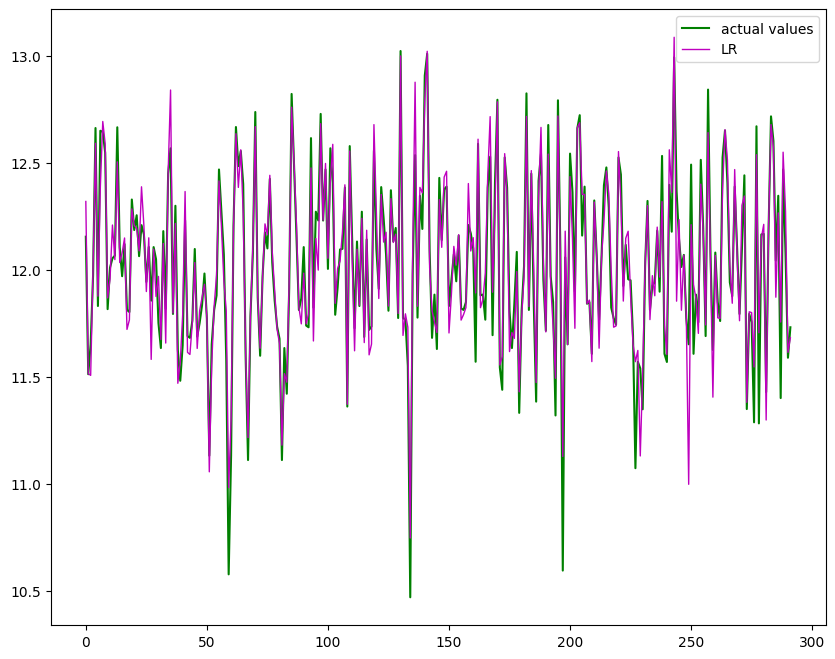

In [15]:
# Plot the prediction and the actual values

def plot_relation(y, preds, name):
    plt.figure(figsize=(10, 8))

    # acutal values
    plt.plot([i for i in range(len(y))],y, c='g', linewidth=1.5, label="actual values")
    # predictions
    plt.plot([i for i in range(len(y))],preds, c='m', linewidth=1, label=name)

    plt.legend()
    plt.show()

predictions = {
    'CB': predictions_cb,
    'XGB': predictions_xgb,
    'LGBM': predictions_lgbm,
    'LR': predictions_lr
}

for name, preds in predictions.items():
    plot_relation(y_val_d, preds, name)

# Create Voting regressor using the previously trained models

In [16]:
model_vote = VotingRegressor([('cb', model_cb), ('xgb', model_xgb), ('lgbm', model_lgbm), ('lr', model_lr)])

if CROSS_VAL:
    scores_vote = cross_val_score(model_vote, X_train.copy(), y_train.copy(), cv=5, scoring='neg_root_mean_squared_error')
    print("Scores Voting Regressor: ", scores_vote)

model_vote.fit(X_train_d, y_train_d)
predictions_vote = model_vote.predict(X_val_d)

rmse_vote = mean_squared_error(y_val_d, predictions_vote, squared=False)
print(f"RMSLE for Voting Regression: {rmse_vote}")

Scores Voting Regressor:  [-0.10371282 -0.11216144 -0.11737353 -0.10149872 -0.10595696]
RMSLE for Voting Regression: 0.11400293426087268


# Predict the test data and submit it

In [17]:
preds_cb = np.expm1(model_cb.predict(X_test))
preds_xgb = np.expm1(model_xgb.predict(X_test))
preds_lgbm = np.expm1(model_lgbm.predict(X_test))
preds_vote = np.expm1(model_vote.predict(X_test))
preds_lr = np.expm1(model_lr.predict(X_test))

sub = pd.read_csv(SAMPLE_SUBMISSION_PATH)

if MODEL == 'cb':
    # Submission file for CB
    sub[TARGET] = preds_cb
    sub.to_csv(SUBMISSION_PATH, index=False)

elif MODEL == 'xgb': 
    # Submission file for XGB
    sub[TARGET] = preds_xgb
    sub.to_csv(SUBMISSION_PATH, index=False)

elif MODEL == 'lgbm':
    # Submission file for LGBM
    sub[TARGET] = preds_lgbm
    sub.to_csv(SUBMISSION_PATH, index=False)
    
elif MODEL == 'lr':
    # Submission file for Linear Regression
    sub[TARGET] = preds_lr
    sub.to_csv(SUBMISSION_PATH, index=False)

elif MODEL == 'vote':
    # Submission file for Voting Regressor
    sub[TARGET] = preds_vote
    sub.to_csv(SUBMISSION_PATH, index=False)